In [30]:

#########################                                                   #######################
#########################           EXPERIMENTUM UNITED                     #######################

#%%
######################################################################################################################
#######   ||||    PREAMBOLO: - acquisiamo i file di INPUT
#######    ||                - eseguiamo operazioni su cartelle
#######    ||   
#######    ||    
#######   ||||


#libraries
import      numpy               as      np
import      matplotlib.pyplot   as      plt
from        lib_Experimentum    import  *
from        Alessandria         import  *
import      time
import      os


#I/O 

now_path            =   '../BRILLOUIN/TDP43/ARS_13_02/'
spectra_filename    =   'ARS_13_02'
VIPA_filename       =   'NO_ARS_13_02_VIPA_quasisat.tif'
log_file            =   'log_'+spectra_filename
analysis_dir       =   'analysis_best_cutted/'

#operatives

#esclusi a mano
to_add              =   [(66, 3),]

syg_kwargs          =   {'height': 80, 'distance': 31, 'width': 3.}
syg_kwargs_VIPA     =   {'distance':70, 'width': 1}
syg_kwargs_brill    =  {'height': 18, 'distance': 31, 'width': 3.}
VIPA_treshold       =   6
sat_height          =   50000
sat_width           =   13.5


#quanto mi allontano dal VIPA
pre_cut             =   False
cut                 =   False
cut_distance        =   0.25
#markov_fit
recover_markov = False
percents_markov     =   ('positive', 0.2, 'positive', np.inf, 'positive', 'positive', 0.2, 0.2, 0.2,  np.inf, np.inf)
#tot fit
percents_tot        = (0.2, 0.1, 0.5, 'positive', 'positive', 0.15,  0.15, 0.15, np.inf, np.inf)

#variables

invisible           =   []
brillouin_higher    =   []
brillouin_highest   =   []
boni                =   []
excluded            =   []

height_first   = ()
height_fourth  = ()


cols        = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position',  'delta_width', 'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_mark   = ('Co', 'Omega', 'Gamma', 'delta_position','delta_width',  'delta_amplitude', 'A', 'mu', 'sigma', 'shift', 'offset')
cols_real   = ('Co', 'Omega', 'Gamma', 'Delta', 'tau', 'delta_position', 'delta_width', 'delta_amplitude','shift', 'offset')
cols_gauss  = ( 'A', 'mu', 'sigma')
# %%
#2) ######################################################################################################################

#######   ||||  ||||    DATA ACQUISITION AND TREATMENT : - acquisiamo i file di INPUT
#######    ||    ||                                  - eseguiamo operazioni su cartelle
#######    ||    ||
#######    ||    ||
#######   ||||  ||||

#import dati spettro
dati    =   Import_from_Matlab(spectra_filename, now_path, var_name = 'y3')
n_rows  =   len(dati)
n_cols  =   len(dati[0])
#matrix, rows, cols = Initialize_Matrix(0,0, 1+1, 1+1)
matrix, rows, cols = Initialize_Matrix(0,0, n_rows, n_cols)
dim     =   len(rows)*len(cols)


os.system('cd ' + now_path +' & mkdir ' + now_path+analysis_dir)
analysis_path            =   now_path +analysis_dir

with open(analysis_path+log_file, 'w') as f_log:
    f_log.write('#This is a log file: you will find info on script run for {}\n'.format(spectra_filename))
    f_log.write('\n\nHo inizializzato una matrice {}x{}, per un totale di {} spettri'.format(len(matrix), len(matrix[0]), len(matrix)*len(matrix[0])))
    
# %%
### riempio oggetti spectrum

tempo = ()
super_start = time.process_time()
start = super_start

matrix[0][0].Get_VIPA_tif(VIPA_filename, now_path, offset = 183.)

for ii in range(len(rows)):
    for jj in range(len(cols)):
        print('Passo row = %d/%d col = %d/%d'%(ii,len(rows)-1, jj, len(cols)-1))
        
        matrix[ii][jj].Get_Spectrum(y = np.resize(dati[ii][jj],np.max(dati[ii][jj].shape)) , offset = 183., cut = pre_cut, cut_range = (200, 600))
        matrix[ii][jj].Get_Spectrum_Peaks(**syg_kwargs)

        matrix[ii][jj].x_VIPA   =   matrix[0][0].x_VIPA
        matrix[ii][jj].y_VIPA   =   matrix[0][0].y_VIPA

### catalogo la natura degli spettri

not_saturated, saturated = Get_Saturated_Elements(matrix, len(rows), len(cols), saturation_height = sat_height, saturation_width = sat_width)
excluded        = saturated.copy()
excluded        = Escludi_a_Mano(to_add, excluded)

for ii in range(len(rows)):
    for jj in range(len(cols)):
            print('Passo row = %d/%d col = %d/%d'%(ii,len(rows)-1, jj, len(cols)-1))
            if (ii,jj) not in excluded:
                #Spettri normali , quattro picchi di cui i picchi più alti sono elastici
                
                if matrix[ii][jj].n_peaks >= 4:
                    matrix[ii][jj].Get_Spectrum_4_Peaks_by_Height()
                    if matrix[ii][jj].Check_Brillouin_Distances(average = 70, stdev = 70/10):
                        invisible += [(ii,jj), ]
                    else: boni += [(ii,jj),]
                elif (matrix[ii][jj].n_peaks == 2):
                    matrix[ii][jj].Get_Spectrum_Peaks(**syg_kwargs_brill)
                    brillouin_highest += [(ii,jj), ]
                    boni += [(ii,jj),]
                elif  (matrix[ii][jj].n_peaks == 3):
                    matrix[ii][jj].Get_Spectrum_Peaks(**syg_kwargs_brill)
                    brillouin_higher += [(ii,jj), ]
                    boni += [(ii,jj),]
                else:
                    raise ValueError("Numero di picchi non previsti ({} )dal codice per spettro {}".format(matrix[ii][jj].n_peaks, str((ii,jj))))

                height_first  += (matrix[ii][jj].peaks['heights'][0],)
                height_fourth += (matrix[ii][jj].peaks['heights'][3],)

acq_time    =   time.process_time()-start
tempo       =   tempo + (('acquisizione', acq_time),)
print('\nTempo impiegato per acquisizione spettri: {} s\n'.format(acq_time))



 row = 81/88 col = 13/84
Passo row = 81/88 col = 14/84
Passo row = 81/88 col = 15/84
Passo row = 81/88 col = 16/84
Passo row = 81/88 col = 17/84
Passo row = 81/88 col = 18/84
Passo row = 81/88 col = 19/84
Passo row = 81/88 col = 20/84
Passo row = 81/88 col = 21/84
Passo row = 81/88 col = 22/84
Passo row = 81/88 col = 23/84
Passo row = 81/88 col = 24/84
Passo row = 81/88 col = 25/84
Passo row = 81/88 col = 26/84
Passo row = 81/88 col = 27/84
Passo row = 81/88 col = 28/84
Passo row = 81/88 col = 29/84
Passo row = 81/88 col = 30/84
Passo row = 81/88 col = 31/84
Passo row = 81/88 col = 32/84
Passo row = 81/88 col = 33/84
Passo row = 81/88 col = 34/84
Passo row = 81/88 col = 35/84
Passo row = 81/88 col = 36/84
Passo row = 81/88 col = 37/84
Passo row = 81/88 col = 38/84
Passo row = 81/88 col = 39/84
Passo row = 81/88 col = 40/84
Passo row = 81/88 col = 41/84
Passo row = 81/88 col = 42/84
Passo row = 81/88 col = 43/84
Passo row = 81/88 col = 44/84
Passo row = 81/88 col = 45/84
Passo row = 81/

In [31]:
#2) Acquisico i dati prodotti dal fit markoviano


##################### MARKOVIANO

with open(analysis_path+'y_markov_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(analysis_path+'cost_markov.txt', 'r') as fin:
    costi = fin.readlines()

with open(analysis_path+'markov_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,   boni) :
    matrix[ii][jj].Recover_Markov_Fit_Params(line)
    matrix[ii][jj].Recover_y_markov_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_markov(float(cost))

print('Ok ho recuperato le informazioni del Fit Markoviano')

costs_markov = ()
for (ii,jj) in boni:
    costs_markov += (matrix[ii][jj].cost_markov,)


Ok ho recuperato le informazioni del Fit Markoviano


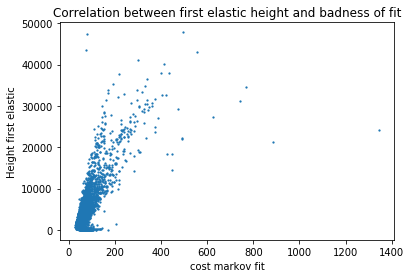

In [32]:
plt.figure()
plt.scatter(costs_markov, height_first, s = 1.5)
plt.xlabel('cost markov fit')
plt.ylabel('Height first elastic')
plt.title('Correlation between first elastic height and badness of fit')
plt.savefig(analysis_path+'correlation_elastic1.pdf', format = 'pdf')

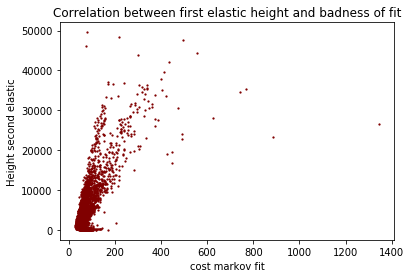

In [33]:
plt.figure()
plt.scatter(costs_markov, height_fourth, s = 1.5, c = 'maroon')
plt.xlabel('cost markov fit')
plt.ylabel('Height second elastic')
plt.title('Correlation between first elastic height and badness of fit')
plt.savefig(analysis_path+'correlation_elastic2.pdf', format = 'pdf')

In [26]:
height_first[0]== height_fourth[0]

False